## Predicting Energy Consumption from PJM (in MW)

Will also be comparing energy consumption from the East and West Regions of the United States as well as their projected energy consumption.

#### Functions & Imports

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly as ply
import scipy.optimize as sp
import math as m
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [44]:
def forecast_future_values(X_VALS, Y_VALS, periods=24, frq='MS'):
    '''
    Create a set of values predicted from an auto-regression model based on
    a given set of data.
    
    Input:
    X_VALS => list of x-values given
    Y_VALS => list of y-values given
    periods (Default: 24) => time alotted; each period (1) corresponds to the frequency input
    frq (Default: 'MS') => the frequency which observations are recorded
    '''
    # Convert X_VALS and Y_VALS to pandas series
    dates = pd.date_range(start='2002-01-01', periods=len(X_VALS), freq=frq)
    data = pd.Series(Y_VALS, index=dates)
    
    # Fit SARIMA model
    # Based on ACF and PACF plots, SARIMA(1,0,1)(1,1,1,12) is chosen
    model = SARIMAX(data, order=(1,0,1), seasonal_order=(1,1,1,12))
    results = model.fit()
    
    # Forecast future values
    forecast = results.forecast(steps=periods) # forecasting for specified num. of periods
    
    return forecast.tolist()

In [45]:
# Importing the csv files and assigning them as dataframes
dfw = pd.read_csv('PJMW_hourly.csv')
dfe = pd.read_csv('PJME_hourly.csv')

#### West-region

In [46]:
# Setting values to floats for 'PJMW_MW'
pd.to_numeric(dfw['PJMW_MW'])

used_year_month = [] # Creating list of already used months per year
year_month = 0 # init the year_month iter var

PJMW_per_month = [] # tmp list for averaging PJMW_MW vals per month
avg_per_year_month = [] # avg PJMW vals per month

# Looping through 'dfw' to sort the data by year and month and create model
for row in dfw.itertuples():
    year_month = row[1][0:7] # ind1 -> tuple key | ind2 -> tuple value
    if year_month in used_year_month: # checks if current year-mnth in list
        PJMW_per_month.append(row[2]) # appends that PJMW value
    elif year_month not in used_year_month: # checks for start of new year
        if not used_year_month: # check for start of loop
            used_year_month.append(year_month) # appends curr year to usedYears list
            continue
        used_year_month.append(year_month) # appends curr year to usedYears list
        tmpAVG = np.average(PJMW_per_month) # averages PJMW vals per year before clearing valsPJMW
        avg_per_year_month.append(round(tmpAVG, 0))
        PJMW_per_month.clear() # clears PJMW vals for new year
    
# Global CONSTANT for length of used_year_month to keep consistancy for future arrays
array_len_ym_const = len(used_year_month)

years_months_list = [] # list of years with dec. for months used for graphing

years_list_curr_val = int(dfw['Datetime'][0][0:4]) # sets current year value to 2002
for i in range(array_len_ym_const): # loops through length of array_length_const
    years_months_list.append(round(years_list_curr_val, 2)) # appends to the list for graphing
    years_list_curr_val += 1 / 12 # math to add onto the list evenly
years_months_list.pop(-1) # removes last value from years_months_list (extra created from loop)

2018.33

In [47]:
used_years = [] # Creating list of already used years
year_ = 0 # init the year iter var

PJMW_per_year = [] # Temp. list for averaging PJMW_MW vals per year
avg_per_year = [] # avg PJMW vals

# Looping through 'dfw' to sort the data by year and create model
for row in dfw.itertuples():
    year_ = row[1][0:4] # ind1 -> tuple key | ind2 -> tuple value
    if year_ in used_years:
        PJMW_per_year.append(row[2])
    elif year_ not in used_years: # checks for start of new year
        if not used_years: # check for start of loop
            used_years.append(year_) # appends curr year to usedYears list
            continue
        used_years.append(year_) # appends curr year to usedYears list
        tmpAVG = np.average(PJMW_per_year) # averages PJMW vals per year before clearing valsPJMW
        avg_per_year.append(round(tmpAVG, 0))
        PJMW_per_year.clear() # clears PJMW vals for new year
        
used_years.pop(-1) # removes year 2018 as there are few PJMW vals for it 
for i in range(len(used_years)): # type converts usedYears vals from str -> int
    used_years[i] = int(used_years[i])

Regression, Interpolation, and Visualization

In [48]:
x_Years_Months = np.array(years_months_list)
y_PJMW_YM = np.array(avg_per_year_month)

x_Years = np.array(used_years)
y_PJMW_Y = np.array(avg_per_year)

In [49]:
start_year = 2018 # year to start regression from
end_year = start_year + 16 # creating a regression of 17 years
end_year_months = start_year + 2 # year to end regression
new_year = [] # list of years after recorded data
for i in range(end_year - start_year): # appends years in order of 2019, 2020, etc.
    new_year.append(start_year + i)
new_years_months = np.linspace(start_year, end_year_months, 24) # year values as list

In [50]:
years_months_list_strings = [] # For x-labels on graph to be formatted correctly
tmp_month = 1 # month number for string
tmp_year = int(dfw['Datetime'][0][0:4]) # year number for string

while tmp_year < end_year_months:
    years_months_list_strings.append(f'{tmp_year}-{tmp_month}')
    if tmp_month == 12:
        tmp_year += 1 # goes to next year after last month
        tmp_month = 1 # resets month to 1st one
    else:
        tmp_month += 1 # iterator for loop

# adds necessary months that was not calculated for from the data
for i in range((len(x_Years_Months) + len(new_years_months)) - len(years_months_list_strings)):
    years_months_list_strings.append(f'{tmp_year}-{i}')

In [51]:
regr_avg_per_year = forecast_future_values(used_years, avg_per_year, periods=16, frq='AS')
regr_avg_per_year_month = forecast_future_values(years_months_list, avg_per_year_month, periods=24, frq='MS')

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61196D+00    |proj g|=  1.11283D-01

At iterate    5    f=  1.53420D+00    |proj g|=  5.94540D-03

At iterate   10    f=  1.52619D+00    |proj g|=  1.80190D-02

At iterate   15    f=  1.52552D+00    |proj g|=  9.05389D-04

At iterate   20    f=  1.52540D+00    |proj g|=  6.86210D-03

At iterate   25    f=  1.52520D+00    |proj g|=  1.03271D-02

At iterate   30    f=  1.52233D+00    |proj g|=  1.53116D-02

At iterate   35    f=  1.48403D+00    |proj g|=  8.79838D-02

At iterate   40    f=  1.47938D+00    |proj g|=  1.49315D-02

At iterate   45    f=  1.47774D+00    |proj g|=  1.89526D-03

At iterate   50    f=  1.47769D+00    |proj g|=  1.53915D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   10    f=  6.90698D+00    |proj g|=  8.29633D-04

At iterate   15    f=  6.90688D+00    |proj g|=  5.27422D-03

At iterate   20    f=  6.90224D+00    |proj g|=  5.86117D-02

At iterate   25    f=  6.87918D+00    |proj g|=  4.88502D-03

At iterate   30    f=  6.87842D+00    |proj g|=  4.81596D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     38      1     0     0   3.113D-05   6.878D+00
  F =   6.8784200123966039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [52]:
y = np.concatenate( # y-vals of graph -> PJMWs
    (avg_per_year_month, regr_avg_per_year_month),
    axis=0)

x = np.array(years_months_list_strings)

# Creating dictionary of labeled columns
yr_m_v_pjmw = {'Year':x, 'PJMW':y}

plot_yr_m_pjmw = pd.DataFrame(yr_m_v_pjmw) # creating dataframe from dictionary for plotting
plot_yr_m_pjmw.describe()

,PJMW
count,220.000000
mean,5559.996173
std,518.307378
min,4573.000000
25%,5110.500000
50%,5510.500000
75%,5945.615563
max,7549.000000


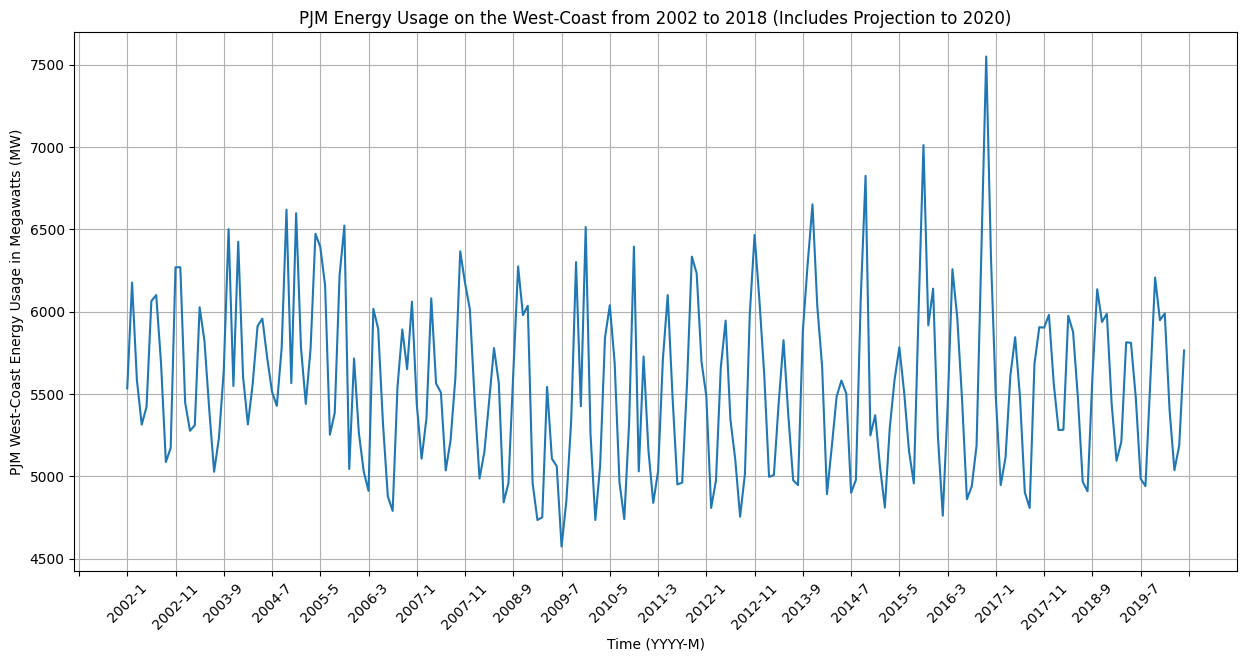

In [53]:
plt.figure(figsize=(15, 7)) # creating figure for plotting

sns.lineplot(data=plot_yr_m_pjmw, # lineplot of data
             x='Year',
             y='PJMW')

# Set x-axis label format
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Set the number of ticks or specify the desired date range for x-axis labels
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(30))  # Set the maximum number of ticks to indicated

# Customizing plot
plt.title('PJM Energy Usage on the West-Coast from 2002 to 2018 (Includes Projection to 2020)')
plt.grid()
plt.ylabel('PJM West-Coast Energy Usage in Megawatts (MW)')
plt.xlabel('Time (YYYY-M)')

# Show plot
plt.show()

In [54]:
yy = np.concatenate(
    (avg_per_year, regr_avg_per_year),
    axis=0
)

xx = np.concatenate(
    (x_Years, new_year),
    axis=0
)

# Creating dictionary of labeled columns
yr_v_pjmw = {'Year':xx,
             'PJMW':yy}

plot_yr_pjmw = pd.DataFrame(yr_v_pjmw) # creating dataframe from dictionary for plotting

Text(0.5, 0, 'Time (Year)')

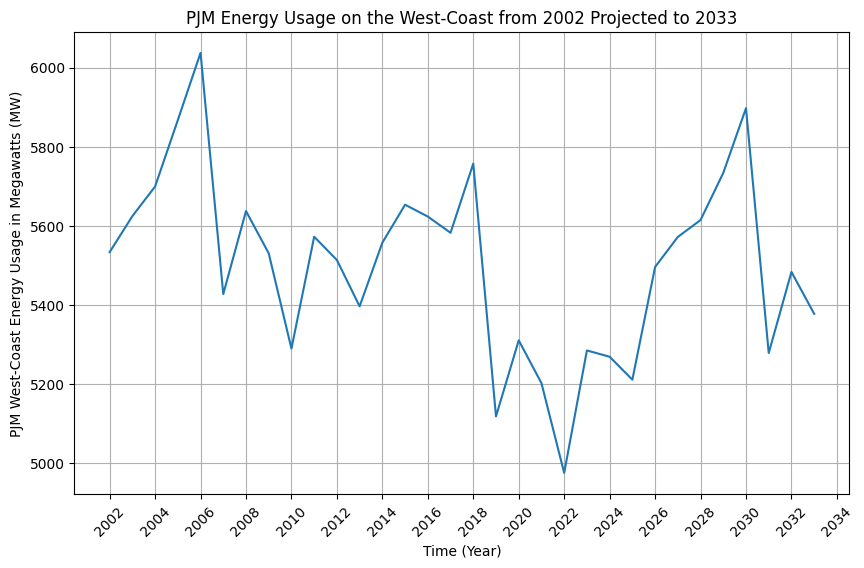

In [59]:
plt.figure(figsize=(10, 6))

sns.lineplot(data=plot_yr_pjmw,
             x='Year',
             y='PJMW')

plt.xticks(rotation=45)

plt.gca().xaxis.set_major_locator(plt.MaxNLocator(20))

plt.title('PJM Energy Usage on the West-Coast from 2002 Projected to 2033')
plt.grid()
plt.ylabel('PJM West-Coast Energy Usage in Megawatts (MW)')
plt.xlabel('Time (Year)')

#### East-region

In [56]:
# Using numerical methods to create a model from each dataset
